In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append("../")
import models
from utils.training import train_meta_model, train_gp
from utils.gp_data import obtain_me_a_nice_gp_dataset_please
from utils.data_utils import ctxt_trgt_split

torch.set_default_dtype(torch.float64)

%load_ext autoreload
%autoreload 2

### Make Dataset

In [2]:
num_datasets = 1000
md = []
# data_hypers = {'l': 1.0, 'kernel': 'per', 'p': 1}
data_hypers = {'l': 0.5, 'kernel': 'se'}
for _ in range(num_datasets):
    X, y = obtain_me_a_nice_gp_dataset_please(n_range=[10, 100], **data_hypers)
    md.append((X, y))

### Initialise Model

In [24]:
# lik = models.GaussianLikelihood(sigma_y = 0.05, train_sigma_y=False)
# # prior = sparse_gp.GPPrior(covariance_function='periodic', num_inputs=1, train_l=True, train_p=True, p=0.5)
# prior = models.GPPrior(covariance_function='squared-exponential', train_l=True)
# num_induc = 32
# use_titsias = False
# sgnp = models.SparseGaussianNeuralProcess(
#     x_dim=1,
#     num_inducing=num_induc,
#     likelihood=lik,
#     prior=prior,
#     cnn_hidden_chans=[32, 32, 32], # ignored if using unet or titsias
#     cnn_kernel_size=5,
#     d_k=8,
#     Z_net_width=32,
#     Z_net_hidden_depth=2,
#     use_transformer=True,
#     nonlinearity=torch.nn.ReLU(),
#     use_titsias=use_titsias,
#     grid_spacing=2e-2,
#     init_cds_ls_multiplier=1,
#     # use_unet=True,
#     # meta_learn_hypers=['l']
# )


# gnp = models.ConvGNP(
#     x_dim=1,
#     cnn_hidden_chans=[32, 32],
#     cnn_kernel_size=3,
#     d_k=8,
#     nonlinearity=torch.nn.ReLU(),
#     grid_spacing=5e-2,
#     init_ls_multiplier=1,
#     # use_unet=True,
# )

cnp = models.CNP(
    x_dim=1,
    deepset_dims=[64, 64, 64],
    decoder_dims=[64, 64],
    nonlinearity=torch.nn.ReLU(),
)

### Train the Model

In [ ]:
# training_metrics = train_meta_model(
#     sgnp,
#     md,
#     training_steps=20_000,
#     batch_size=5,
#     learning_rate=1e-3,
#     final_learning_rate=5e-5,
#     num_samples=5,
#     loss_function='vi',
# )

training_metrics = train_meta_model(
    cnp,
    md,
    training_steps=20_000,
    batch_size=5,
    learning_rate=1e-3,
    final_learning_rate=5e-5,
    loss_function='npml',
    include_ctxt_in_trgt=True,
    # ctxt_proportion_range=(0.05, 0.5),  # for simple data
    ctxt_proportion_range=(0.25, 0.75)
)

100%|██████████| 20000/20000 [00:47<00:00, 422.58it/s, ll=-55.4, Epochs=100] 


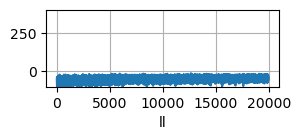

In [26]:
fig, axes = plt.subplots(1, len(training_metrics), figsize=(3*len(training_metrics), 1))
if not isinstance(axes, list):
    axes = [axes]
omitted_steps = 50
for i, (key, value) in enumerate(training_metrics.items()):
    axes[i].plot(value[omitted_steps:])
    axes[i].set_xlabel(key)
    axes[i].grid()
    axes[i].set_ylim([-100, 400])
plt.show()


### Visualise test predictions

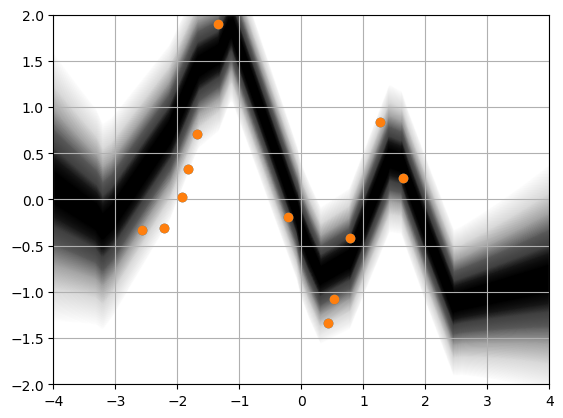

In [33]:
# torch.manual_seed(12)
X, y = obtain_me_a_nice_gp_dataset_please(n_range=[5, 30], **data_hypers)
shift = 0.0
# X, y =  md[torch.randint(0, len(md), (1,)).item()]
X_c, y_c = X.clone(), y.clone()

xs = torch.linspace(-5.0, 5.0, 500).unsqueeze(-1)
X_c += shift
xs += shift
with torch.no_grad():
    # preds = sgnp(xs, X_c, y_c)
    # preds = gnp(X_c, y_c, xs)
    preds = cnp(X_c, y_c, xs)

if isinstance(preds, torch.distributions.MultivariateNormal):
    mu = preds.mean
    sig = preds.variance.sqrt()
elif isinstance(preds, torch.distributions.Normal):
    mu = preds.mean
    sig = preds.scale

# plt.fill_between(xs.squeeze(), mu - 2*sig, mu + 2*sig, alpha=0.9)
cont_gran = 200
for cont in range(cont_gran):
    c = cont / cont_gran
    plt.fill_between(xs.squeeze(), mu-2*c*sig, mu+2*c*sig, color='black', alpha=0.03*(1-c)**2)
plt.scatter(X_c, y_c, color='C1', zorder=10000)
plt.scatter(X_c, y_c)
plt.grid()
plt.xlim([-4.0+shift, 4.0+shift])
plt.ylim([-2.0, 2.0])
plt.show()

In [ ]:
# gp_prior = sparse_gp.GPPrior(covariance_function='periodic', train_l=True, train_p=True)
gp_prior = models.GPPrior(covariance_function='squared-exponential', train_l=True)
gp = models.GaussianProcess(num_inputs=1, prior=gp_prior, train_sigma_y=True)

gp_training_metrics = train_gp(
    gp,
    X_c,
    y_c,
    epochs=5_000,
    learning_rate=1e-2,
    final_learning_rate=1e-3
)

fig, axes = plt.subplots(1, len(gp_training_metrics), figsize=(3*len(gp_training_metrics), 1))
# if not isinstance(axes, list):
#     axes = [axes]
omitted_steps = 50
for i, (key, value) in enumerate(gp_training_metrics.items()):
    axes[i].plot(value[omitted_steps:])
    axes[i].set_xlabel(key)
    axes[i].grid()
plt.show()

In [ ]:
with torch.no_grad():
    preds = gp(xs, X_c, y_c, multivariate=False)
mu = preds.mean
sig = preds.variance.sqrt()

# plt.fill_between(xs.squeeze(), mu - 2*sig, mu + 2*sig, alpha=0.9)
cont_gran = 200
for cont in range(cont_gran):
    c = cont / cont_gran
    plt.fill_between(xs.squeeze(), mu-2*c*sig, mu+2*c*sig, color='black', alpha=0.03*(1-c)**2)
plt.scatter(X_c, y_c, color='C1', zorder=10000)
plt.scatter(X_c, y_c)
plt.grid()
plt.xlim([-4.0+shift, 4.0+shift])
plt.ylim([-2.0, 2.0])
plt.show()

In [ ]:
num_test_sets = 100
per_point_lls = torch.zeros((num_test_sets))


for i in tqdm(range(num_test_sets), disable=False):
    torch.manual_seed(i)
    X, y,  = obtain_me_a_nice_gp_dataset_please(n_range=[20, 200], **data_hypers)
    X_c, y_c, X_t, y_t = ctxt_trgt_split(X, y, ctxt_proportion_range=[0.45, 0.55])

    gp_prior = models.GPPrior(covariance_function='squared-exponential', l=0.5, train_l=False)
    gp = models.GaussianProcess(num_inputs=1, prior=gp_prior, train_sigma_y=False, sigma_y=0.05)

    # _ = train_gp(
    #         gp,
    #         X_c,
    #         y_c,
    #         epochs=5_000,
    #         learning_rate=5e-3,
    #         final_learning_rate=1e-3,
    #         silent=True
    #     )
    

    with torch.no_grad():
        # predictive = sgnp(X_t, X_c, y_c, multivariate=True)
        # per_point_lls[i] = predictive.log_prob(y_t.squeeze()) / y_t.shape[0]

        # predictive = gnp(X_c, y_c, X_t)
        # per_point_lls[i] = predictive.log_prob(y_t.squeeze()) / y_t.shape[0]

        predictive = gp(X_t, X_c, y_c, multivariate=True)
        per_point_lls[i] = predictive.log_prob(y_t.squeeze()) / y_t.shape[0]


print(per_point_lls.mean(), per_point_lls.std()/10)
